# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Importing

In [1]:
# Link for downloaiding the dataset: https://zenodo.org/records/12554005
# After unzipping the dataset the full images can be found in the "\ami_traps\ami_traps_dataset\images" folder

import os
import cv2
import json
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import shutil
from glob import glob
from collections import Counter

# Paths
images_path = "../dataset/images"
labels_path = "../dataset/labels"
output_path = "../dataset/dataset_split"
class_json_path = "../dataset/notes.json"

## Data Understanding

### Valid image files collection

In [2]:
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
image_paths = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.lower().endswith(valid_exts)]
print(f"✅ Found {len(image_paths)} images in {images_path}")

✅ Found 2893 images in ../dataset/images


### Corrupted or non-image files detection

In [3]:
bad_files = []
for path in image_paths:
    try:
        Image.open(path).verify()
    except Exception as e:
        bad_files.append((path, str(e)))

if bad_files:
    print(f"⚠️ Found {len(bad_files)} corrupted images:")
    for bf in bad_files:
        print(" -", bf[0])
else:
    print("✅ No corrupted images detected.")

✅ No corrupted images detected.


### Some Images

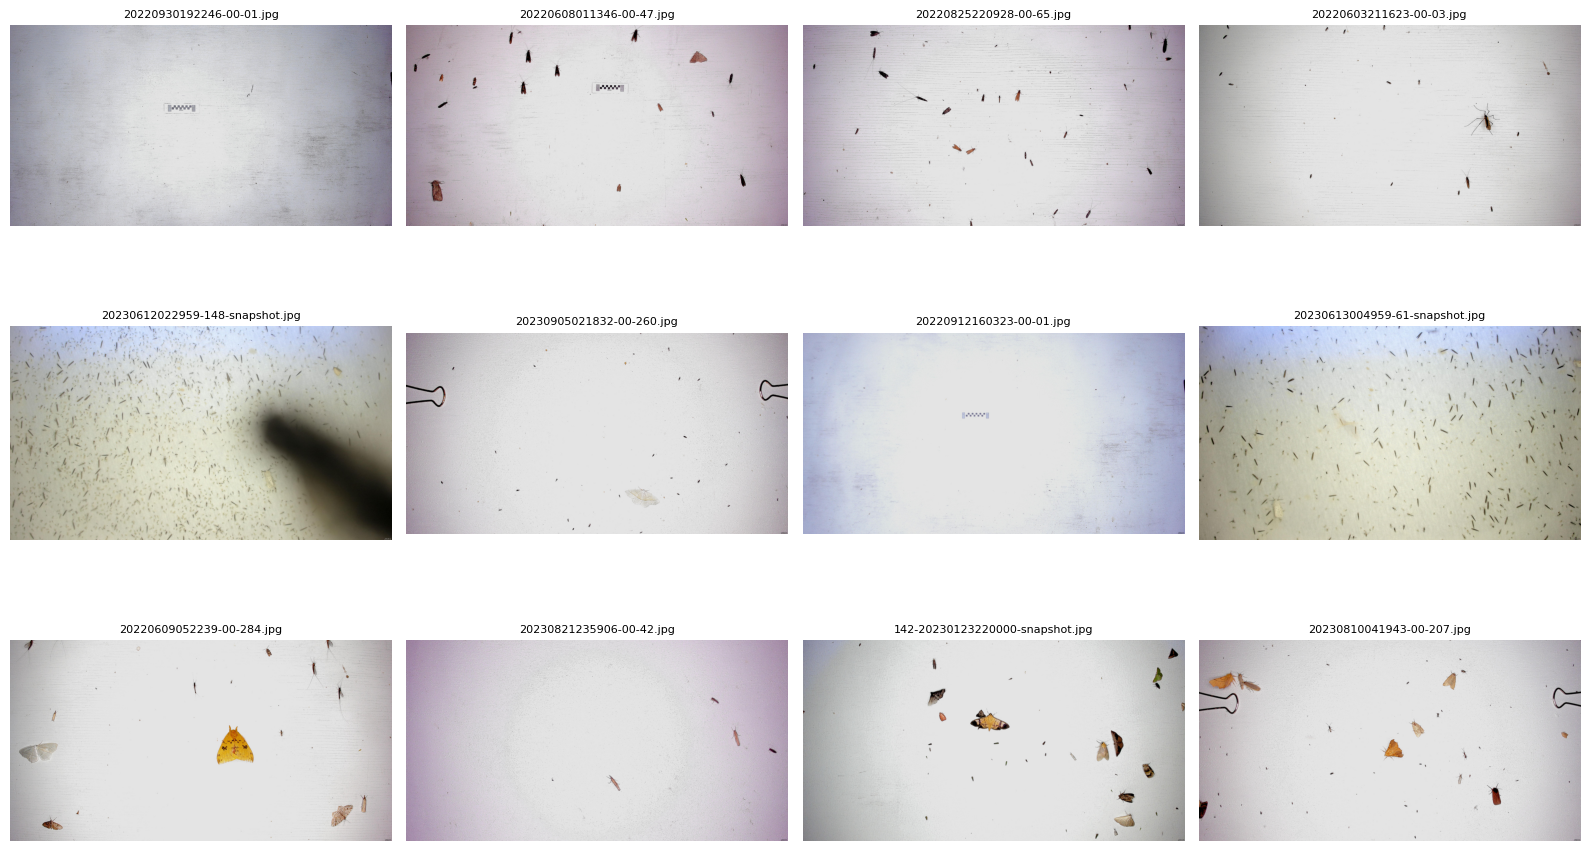

In [4]:
def show_random_images(image_list, n_rows=3, n_cols=4):
    """Display a grid of random images."""
    plt.figure(figsize=(16, 10))
    for i in range(n_rows * n_cols):
        idx = random.randint(0, len(image_list) - 1)
        img_path = image_list[idx]
        try:
            img = mpimg.imread(img_path)
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path), fontsize=8)
            plt.axis("off")
        except Exception:
            continue
    plt.tight_layout()
    plt.show()

show_random_images(image_paths)

### Directory Structure Understanding

First, there is an **images** directory that contains all the images, each featuring one or more insects. Then, there is a **labels** directory that contains text files with **annotation data**. Each text file includes the insect’s **class id and the pixel coordinates** of its location within the corresponding image. There is one text file per image, and each text file **shares the same filename** as its associated image.

There is also another text file called **classes** which contains all the classes of insects that got detected.

Another json file is there called **note** which contains classes with their **id** and **rank**.

The image files in images directory is connected to label text files in labels directory by having the same name. Label text file connected with note json file through the class id.

### Drawing Rectangles

Then the coordinates from the text files are used to created rectangles to check if data are accurate.

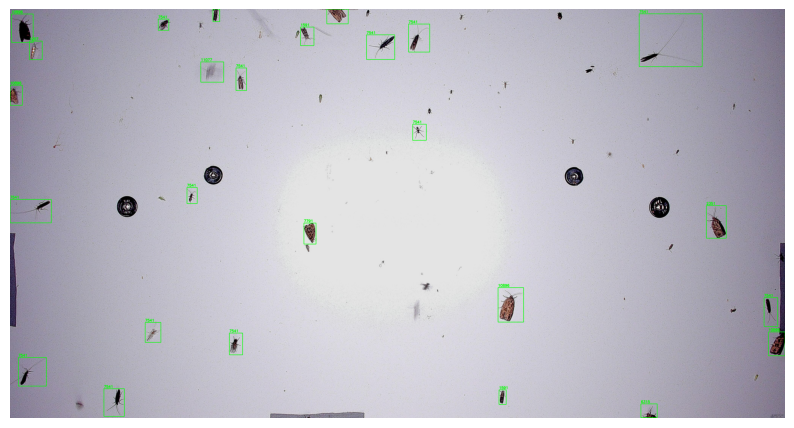

In [5]:
test_image_path = f"{images_path}/20-20220716220000-snapshot.jpg"
test_label_path = f"{labels_path}/20-20220716220000-snapshot.txt"

# Read image using OpenCV (in BGR format)
image = cv2.imread(test_image_path)

# Get image dimensions
h, w, _ = image.shape

# Read YOLO labels (in the labels .txt files)
with open(test_label_path, "r") as f:
    lines = f.readlines()

# Draw boxes on image
for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bw, bh = map(float, parts[1:])

    # Convert normalized coordinates to pixel values
    x_center *= w
    y_center *= h
    bw *= w
    bh *= h

    # Get top-left and bottom-right corners
    x1 = int(x_center - bw / 2)
    y1 = int(y_center - bh / 2)
    x2 = int(x_center + bw / 2)
    y2 = int(y_center + bh / 2)

    # Draw rectangle and class ID
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 255, 0), 2)

# Convert BGR to RGB (for correct color display in matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

### Counting Classes

We count how many classes of insect are there in the data.

In [8]:
def count_class_ids_with_names():
    # Load class mapping from JSON
    with open(class_json_path, "r") as f:
        data = json.load(f)

    id_to_name = {str(cat["id"]): cat["name"] for cat in data["categories"]}

    # Count class IDs across all label files
    class_counts = Counter()

    for filename in os.listdir(labels_path):
        if not filename.endswith(".txt"):
            continue

        file_path = os.path.join(labels_path, filename)

        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = parts[0]
                class_counts[class_id] += 1

    # Map IDs to insects' names
    results = {}
    for class_id, count in class_counts.items():
        name = id_to_name.get(class_id, "Unknown")
        results[f"({name}) {class_id}"] = count

    # Print in sorted way
    for name_id, count in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{name_id}: {count}")
        
    print(f"There are {len(results.items())} classes of insects")

count_class_ids_with_names()

(Non-Moth) 7541: 37105
(Moth) 7243: 1893
(Unidentifiable) 11077: 1738
(Tortricidae) 10896: 1729
(Lepidoptera) 6315: 1358
(Chrysoteuchia culmella) 2392: 562
(Crambidae) 2991: 367
(Choristoneura fumiferana) 2351: 334
(Geometridae) 5121: 317
(Hypoprepia fucosa) 5953: 255
(Macaria sp.) 6714: 200
(Crambus sp.) 3031: 194
(Cnephasia stephensiana) 2501: 183
(Crambini) 2997: 182
(Pandemis limitata) 8134: 178
(Yponomeuta sp.) 11304: 173
(Campaea perlata) 1912: 171
(Scopariinae) 9826: 163
(Noctuidae) 7504: 129
(Hyphantria cunea) 5920: 122
(Microcrambus elegans) 7069: 122
(Choristoneura sp.) 2358: 120
(Palpita magniferalis) 8083: 119
(Choristoneura rosaceana) 2357: 107
(Hydrelia inornata) 5800: 96
(Archipini) 1138: 88
(Dryocampa rubicunda) 3694: 81
(Drepana arcuata) 3652: 77
(Spilosoma lubricipeda) 10175: 74
(Eupithecia sp.) 4774: 72
(Notodontidae) 7575: 67
(Idaea aversata) 5981: 67
(Pandemis lamprosana) 8133: 64
(Eilema lurideola) 3852: 60
(Gelechiidae) 5112: 57
(Calliteara pudibunda) 1808: 57
(P

## Data Preparation

### Data Cleaning

#### Removing Insects with NA rank

We remove all the insect with NA rank because they are unnecessary for training our model. This function can be reused to remove unwanted classes (few images available).

In [9]:
## removing insects with rank 11077, 11431, 7541

def remove_class_from_labels(class_id_to_remove):
    class_id_to_remove = str(class_id_to_remove)

    counter = 0

    # Loop through all text files
    for filename in os.listdir(labels_path):
        if not filename.endswith(".txt"):
            continue

        label_path = os.path.join(labels_path, filename)

        # Read all lines except those matching the class ID
        with open(label_path, "r") as f:
            lines = f.readlines()

        filtered_lines = [line for line in lines if not line.strip().startswith(class_id_to_remove + " ")]

        # Overwrite file only if something changed
        if len(filtered_lines) != len(lines):
            with open(label_path, "w") as f:
                f.writelines(filtered_lines)
            counter += 1
            # print(f"Updated: {filename} (removed {class_id_to_remove})")

    print(f"Removed class id {class_id_to_remove} -- {counter} times")

unwanted_class_ids = [11077, 11431, 7541]

for class_id in unwanted_class_ids:
    remove_class_from_labels(class_id)

print("Done")

Removed class id 11077 -- 818 times
Removed class id 11431 -- 0 times
Removed class id 7541 -- 2089 times
Done


#### Rechecking Class Count

In [10]:
count_class_ids_with_names()

(Moth) 7243: 1893
(Tortricidae) 10896: 1729
(Lepidoptera) 6315: 1358
(Chrysoteuchia culmella) 2392: 562
(Crambidae) 2991: 367
(Choristoneura fumiferana) 2351: 334
(Geometridae) 5121: 317
(Hypoprepia fucosa) 5953: 255
(Macaria sp.) 6714: 200
(Crambus sp.) 3031: 194
(Cnephasia stephensiana) 2501: 183
(Crambini) 2997: 182
(Pandemis limitata) 8134: 178
(Yponomeuta sp.) 11304: 173
(Campaea perlata) 1912: 171
(Scopariinae) 9826: 163
(Noctuidae) 7504: 129
(Hyphantria cunea) 5920: 122
(Microcrambus elegans) 7069: 122
(Choristoneura sp.) 2358: 120
(Palpita magniferalis) 8083: 119
(Choristoneura rosaceana) 2357: 107
(Hydrelia inornata) 5800: 96
(Archipini) 1138: 88
(Dryocampa rubicunda) 3694: 81
(Drepana arcuata) 3652: 77
(Spilosoma lubricipeda) 10175: 74
(Eupithecia sp.) 4774: 72
(Notodontidae) 7575: 67
(Idaea aversata) 5981: 67
(Pandemis lamprosana) 8133: 64
(Eilema lurideola) 3852: 60
(Gelechiidae) 5112: 57
(Calliteara pudibunda) 1808: 57
(Pyralidae) 9409: 56
(Tortricinae) 10901: 55
(Apotomis

#### Removing Images Without Insects

We found out some of the images do not have any insects on it. We find them from empty text files.

In [11]:
image_extensions = [".jpg", ".png", ".jpeg"]

counter = 0

# Loop through label files
for label_file in os.listdir(labels_path):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(labels_path, label_file)

    # Check if label file is empty or contains only whitespace
    if os.path.getsize(label_path) == 0 or not open(label_path).read().strip():
        base_name = os.path.splitext(label_file)[0]

        # Try to find the corresponding image
        removed_image = False
        for ext in image_extensions:
            image_path = os.path.join(images_path, base_name + ext)
            if os.path.exists(image_path):
                os.remove(image_path)
                counter += 1
                # print(f"Removed image: {image_path}")
                removed_image = True
                break

        # Remove the label file itself
        os.remove(label_path)
        # print(f"Removed empty label: {label_path}")

        if not removed_image:
            print(f"No matching image found for label {label_file}")

print(f"Cleanup complete: all empty label files and matching images removed ({counter} images).")

Cleanup complete: all empty label files and matching images removed (640 images).


#### Removing Unwanted Classes

Removing classes with very few images. **Need to be updated**

In [ ]:
## TODO: fill up the list with id of unwanted classes.
unwanted_class_ids = []

for class_id in unwanted_class_ids:
    remove_class_from_labels(class_id)

### Data Augmentation

As it can be observed that there are some huge class imbalances. To fix that we introduce data augmentation to increase number images for the classes that have fewer existing images. 

### Spliting Dataset

**Needs to updated** to have each section to have same number of classes.

#### Into train/valid/test

In [ ]:
# Create folders
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_path}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_path}/labels/{split}", exist_ok=True)

# Split
image_files = glob(f"{images_path}/*.jpg")  # or .png that can be add later
random.shuffle(image_files)

n = len(image_files)
train_end = int(0.7 * n)
val_end = int(0.9 * n)

splits = {
    "train": image_files[:train_end],
    "val": image_files[train_end:val_end],
    "test": image_files[val_end:]
}

# Move corresponding images and labels
for split, files in splits.items():
    for img_path in files:
        filename = os.path.basename(img_path)
        label_path = os.path.join(labels_path, filename.replace(".jpg", ".txt"))

        shutil.copy(img_path, f"{output_path}/images/{split}/{filename}")
        shutil.copy(label_path, f"{output_path}/labels/{split}/{filename.replace('.jpg', '.txt')}")

print("Data splitting done!")

#### Image Count Per Section

In [ ]:
def number_of_images(image_dir): 
    return len([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)])
            
print(f"For training {number_of_images(f"{output_path}/images/train")} images")
print(f"For validating {number_of_images(f"{output_path}/images/val")} images")
print(f"For testing {number_of_images(f"{output_path}/images/test")} images")